##PURPOSE

The purpose of this notebook is to show how a random forest model performs for the Restaurant Revenue Prediction competition which tasks you with predicting the annual restaurant sales of 100,000 regional locations. Hopefully, this notebook can serve as a guide to walk you through the modeling process. Improvements and/or suggestions for the methods shown here are always welcome! I will also try to point out areas where I feel improvements could be made too.

In [9]:
import random 
random.seed(123)

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
import operator as op

import seaborn as sns
sns.set(rc={'figure.figsize': (12,8)})

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [10]:
# Display output from multiple commands
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data Importing and Cleaning

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
train = pd.read_csv("/content/drive/MyDrive/train.csv.zip")
test = pd.read_csv("/content/drive/MyDrive/test.csv.zip")


In [12]:
train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0


In [13]:
test.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,2,5,4,5,5,5,3,4.0,0,0,0,2,0,5,5,3,1,4,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,2,5,3,4,4,2,4,5.0,0,0,0,0,0,5,5,3,2,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,2,5,4,4,5,4,5,5.0,0,0,0,0,0,5,5,5,5,5,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,3,5,4,5,4,3,4,5.0,0,0,0,0,4,4,4,3,2,2,0,0,0.0,0.0,2.0,3.0,0,4,0,0,0,0,0,0
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,2,5,4,5,4,3,5,4.0,0,0,0,0,0,1,5,3,1,1,0,0,0.0,0.0,5.0,3.0,0,0,0,0,0,0,0,0


In [14]:
# General info on the dataset
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 43 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          137 non-null    int64  
 1   Open Date   137 non-null    object 
 2   City        137 non-null    object 
 3   City Group  137 non-null    object 
 4   Type        137 non-null    object 
 5   P1          137 non-null    int64  
 6   P2          137 non-null    float64
 7   P3          137 non-null    float64
 8   P4          137 non-null    float64
 9   P5          137 non-null    int64  
 10  P6          137 non-null    int64  
 11  P7          137 non-null    int64  
 12  P8          137 non-null    int64  
 13  P9          137 non-null    int64  
 14  P10         137 non-null    int64  
 15  P11         137 non-null    int64  
 16  P12         137 non-null    int64  
 17  P13         137 non-null    float64
 18  P14         137 non-null    int64  
 19  P15         137 non-null    i

In [15]:
# Count the number of null values
train.isnull().sum()
test.isnull().sum()

Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
revenue       0
dtype: int64

Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
dtype: int64

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02
mean,68.000000,4.014599,4.408759,4.317518,4.372263,2.007299,3.357664,5.423358,5.153285,5.445255,5.489051,3.262774,5.299270,5.080292,1.416058,1.386861,1.941606,1.036496,1.941606,4.905109,4.547445,2.270073,2.226277,3.423358,1.372263,1.211679,1.470803,1.145985,3.222628,3.135036,2.729927,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788,4.453533e+06
std,39.692569,2.910391,1.514900,1.032337,1.016462,1.209620,2.134235,2.296809,1.858567,1.834793,1.847561,1.910767,1.941668,1.036527,2.729583,2.398677,3.505807,2.030679,3.300549,5.604467,3.708041,2.052630,1.230690,4.559609,2.304112,2.133179,2.612024,2.067039,2.308806,1.680887,5.536647,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768,2.576072e+06
min,0.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.149870e+06
25%,34.000000,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,5.000000,2.000000,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.999068e+06
50%,68.000000,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,5.000000,5.000000,5.000000,3.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,4.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.500000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.939804e+06
75%,102.000000,4.000000,5.000000,5.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,2.000000,2.000000,3.000000,1.000000,4.000000,5.000000,5.000000,3.000000,3.000000,5.000000,2.000000,2.000000,2.500000,2.000000,4.000000,3.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.166635e+06
max,136.000000,12.000000,7.500000,7.500000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,7.500000,15.000000,10.000000,15.000000,15.000000,12.000000,25.000000,15.000000,15.000000,5.000000,25.000000,10.000000,10.000000,12.500000,12.500000,12.500000,7.500000,25.000000,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000,1.969694e+07


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'P(revenue)'), Text(0.5, 0, 'revenue')]

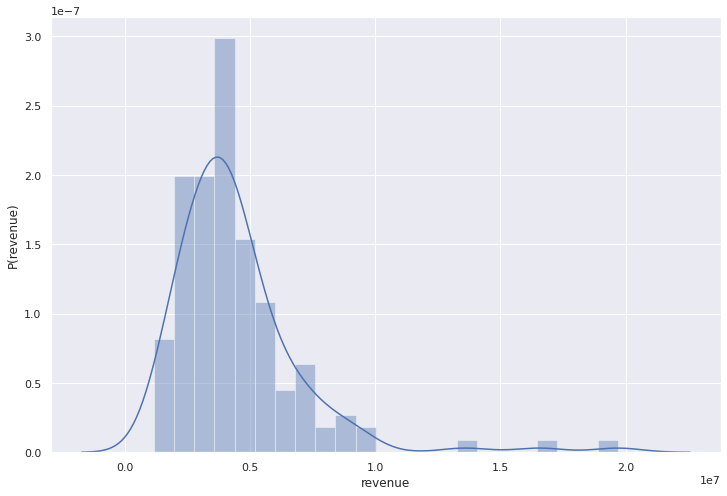

In [16]:
train.describe()
sns.distplot(a=train['revenue'], kde=True).set(xlabel='revenue', ylabel='P(revenue)')

The histogram is showing that target vaiable is a right-skewed distribution.
There are outliers which have revenue >10.000.000 will effect the results. These outliers should be removed from the dataset.

In [17]:
# To check which city has maximum number of restaurants
train["City"].value_counts()

İstanbul          50
Ankara            19
İzmir              9
Bursa              5
Samsun             5
Antalya            4
Sakarya            4
Eskişehir          3
Diyarbakır         3
Kayseri            3
Tekirdağ           3
Adana              3
Trabzon            2
Aydın              2
Muğla              2
Konya              2
Amasya             1
Şanlıurfa          1
Karabük            1
Osmaniye           1
Denizli            1
Elazığ             1
Gaziantep          1
Isparta            1
Uşak               1
Afyonkarahisar     1
Balıkesir          1
Edirne             1
Tokat              1
Kütahya            1
Kastamonu          1
Bolu               1
Kocaeli            1
Kırklareli         1
Name: City, dtype: int64

In [18]:
train.shape

(137, 43)

In [19]:
train.drop(['Id'], axis=1)

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0
1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0
2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0
3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0
4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,06/25/2008,Trabzon,Other,FC,2,3.0,3.0,5.0,4,2,4,4,4,4,4,4,4.0,0,0,0,0,0,4,3,2,1,1,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,5787594.0
133,10/12/2006,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,3,5,4,4,5,5,4,5.0,0,0,0,0,0,3,2,2,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,9262754.0
134,07/08/2006,Kayseri,Other,FC,3,4.0,4.0,4.0,2,3,5,5,5,5,1,5,5.0,0,0,0,0,0,2,3,1,2,2,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2544857.0
135,10/29/2010,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,2,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,7217634.0


# Exploratory Data Analysis

In [20]:
# Find the sets of categorical variables and numberical variales for feature analyses 
numerical_features = train.select_dtypes([np.number]).columns.tolist()
categorical_features = train.select_dtypes(exclude = [np.number,np.datetime64]).columns.tolist()
print(categorical_features)
print(numerical_features)

['Open Date', 'City', 'City Group', 'Type']
['Id', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'revenue']


In [31]:
train['Open Date'] = pd.to_datetime(train['Open Date'], format= '%m/%d/%Y')
train['OpenDays']=""

dateLastTrain = pd.DataFrame({'Date':np.repeat(['01/01/2020'],[len(train)]) })
dateLastTrain['Date'] = pd.to_datetime(dateLastTrain['Date'], format= '%m/%d/%Y' )
dateLastTrain.head()

train['OpenDays'] = dateLastTrain['Date'] - train['Open Date']
train['OpenDays'] = train['OpenDays'].astype('timedelta64[D]').astype(int)

,Date
0,2020-01-01
1,2020-01-01
2,2020-01-01
3,2020-01-01
4,2020-01-01


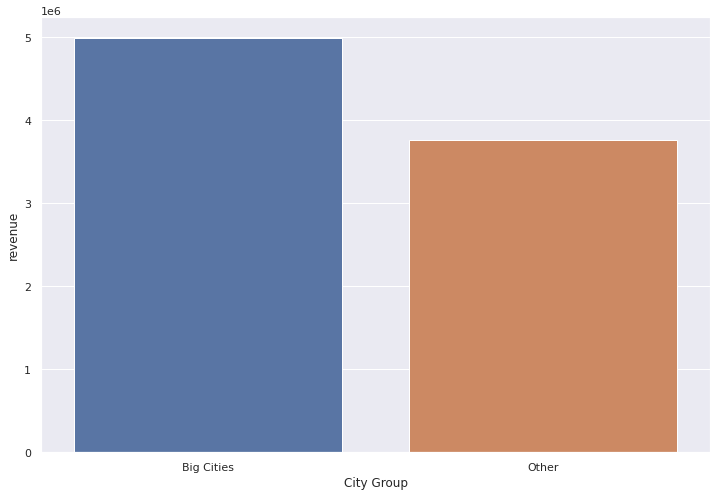

In [22]:
cityPerc = train[['City Group', 'revenue']].groupby(['City Group'],as_index=False).mean()
sns.barplot(x= 'City Group', y='revenue', data=cityPerc)

[Text(0.5, 1.0, 'Whisker plot')]

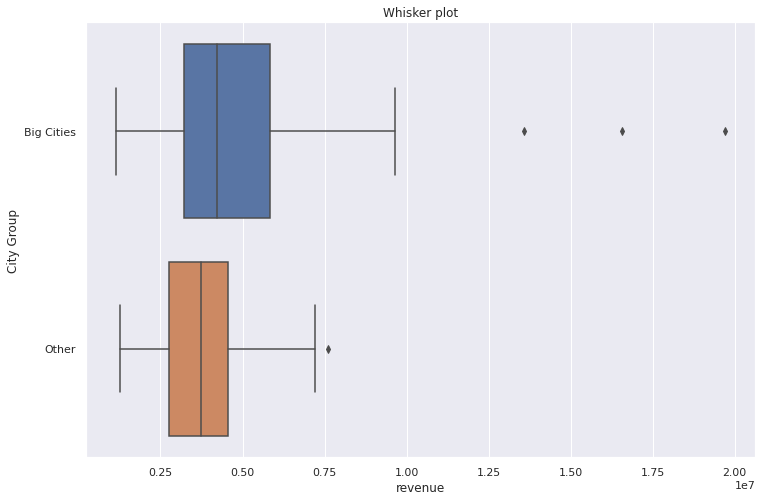

In [23]:
#Revenue of big cities and other cities
ax_wp_1 = sns.boxplot(x='revenue', y='City Group', data=train)
ax_wp_1.set(title='Whisker plot');

bc_mean = train[train['City Group'] == 'Big Cities']['revenue'].mean()
oc_mean = train[train['City Group'] == 'Other']['revenue'].mean()

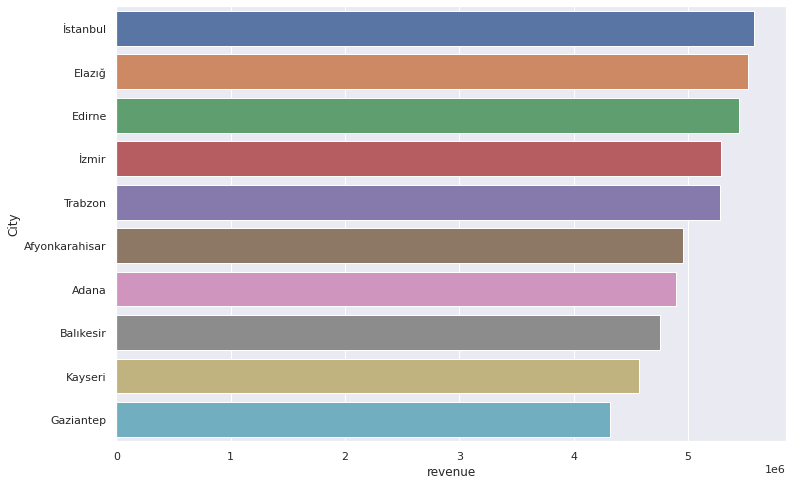

In [24]:
cityPerc = train[['City','revenue']].groupby(['City'],as_index=False).mean()
newDF = cityPerc.sort_values(['revenue'],ascending= False)
sns.barplot(x='revenue', y='City', data=newDF.head(10))

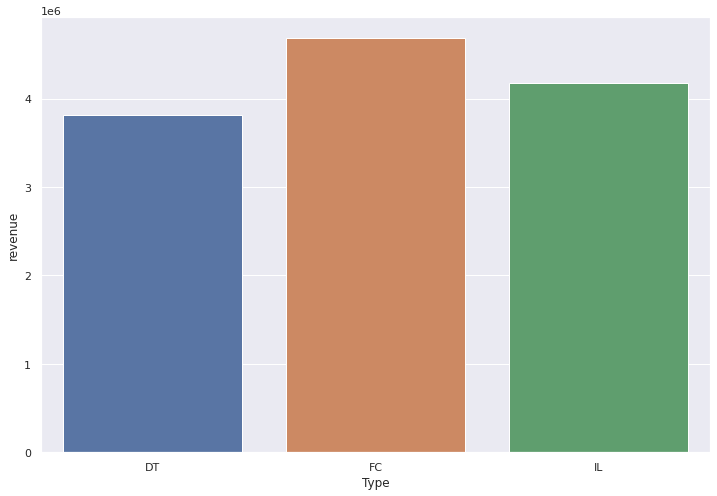

In [26]:
cityPerc = train[['Type','revenue']].groupby(['Type'],as_index=False).mean()
sns.barplot(x='Type', y='revenue', data=cityPerc)

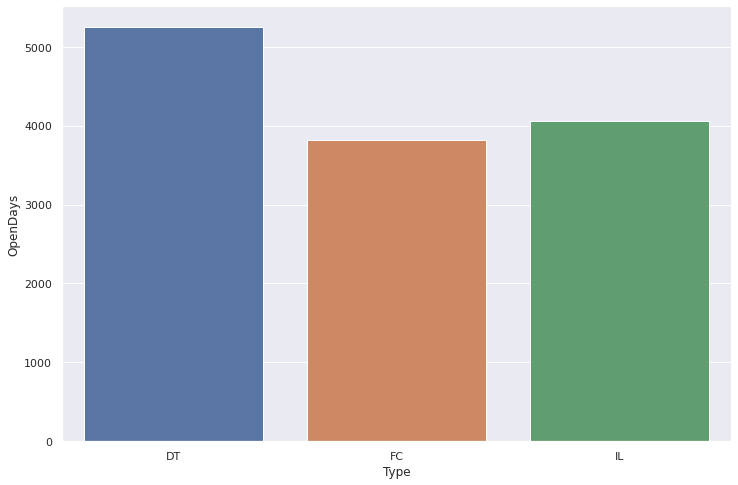

In [27]:
cityPerc = train[['Type','OpenDays']].groupby(['Type'],as_index=False).mean()
sns.barplot(x='Type', y='OpenDays', data=cityPerc)

Now let us convert the 'Open Date' feature in datetime format so that we can extract the month and year from it. We want to do this because the date doesn't give us any insight of the revenue. But the month and year surely does.

In [32]:
train['Open Date'] = pd.to_datetime(train['Open Date'])

In [33]:
train['month']=[x.month for x in train['Open Date']]

In [34]:
train['year']=[x.year for x in train['Open Date']]

<Figure size 1080x432 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


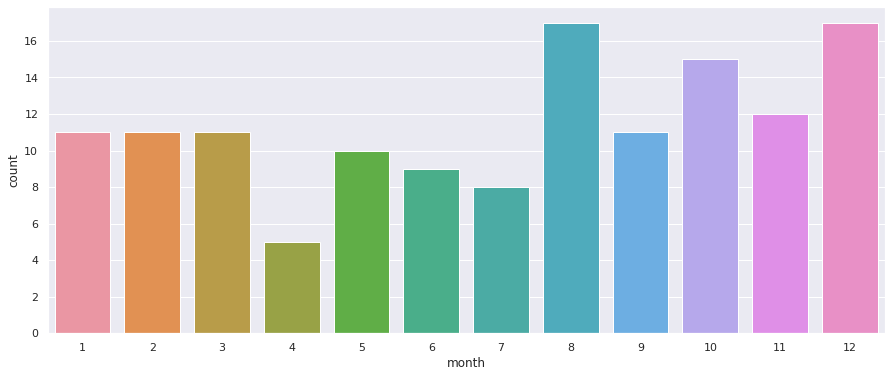

In [35]:
plt.figure(figsize=(15,6))
sns.countplot(train['month'])

From the above plot we can look at the occurence of various months in the dataset. We have the most data for the last 5 months. The highest of them is from August and December. Now let's see in which month did we have the most revenue. For this let us to find the mean of the revenue for each month.

In [36]:
train.groupby('month')['revenue'].mean()

month
1     5.900851e+06
2     4.189109e+06
3     3.969557e+06
4     4.726097e+06
5     3.657800e+06
6     3.776214e+06
7     3.458596e+06
8     3.883020e+06
9     5.390856e+06
10    5.236838e+06
11    4.721400e+06
12    4.299763e+06
Name: revenue, dtype: float64

From here we can see that the month January gave the most revenue to the restraunts. September and October followed January. Let's try to plot a bargraph with the same and visualize the same trends.

In [37]:
# Label Encoding
cat_vars = ['City', 'City Group', 'Type']
for i in cat_vars:
    train[i+"_cat"] = train[i].astype('category').cat.codes
# df.drop(cat_vars, axis=1, inplace=True)
train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,OpenDays,City_cat,City Group_cat,Type_cat,month,year
0,0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,7473,31,0,2,7,1999
1,1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,4339,3,0,1,2,2008
2,2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,2489,10,1,2,3,2013
3,3,2012-02-02,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,2890,28,1,2,2,2012
4,4,2009-05-09,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,3889,14,1,2,5,2009


<Figure size 1080x432 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


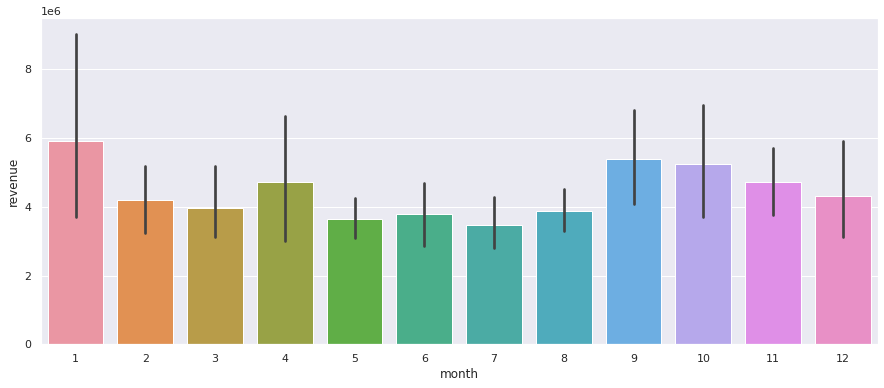

In [38]:
plt.figure(figsize=(15,6))
sns.barplot('month','revenue',data=train)

So these bargraphs are giving out the same information. Now lets try to do same kind of stuffs for the newly generated feature 'year'.

<Figure size 1080x432 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


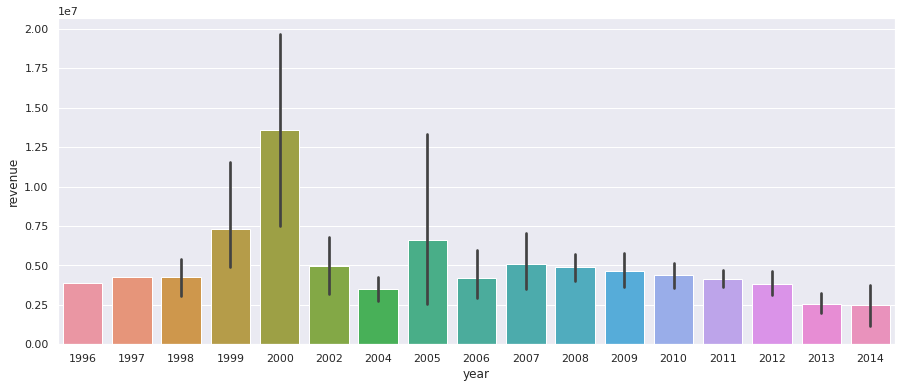

In [39]:
plt.figure(figsize=(15,6))
sns.barplot('year','revenue',data=train)

Out of all the years, the highest revenue was generated in the year 2000 and after that 1999 and 2005.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


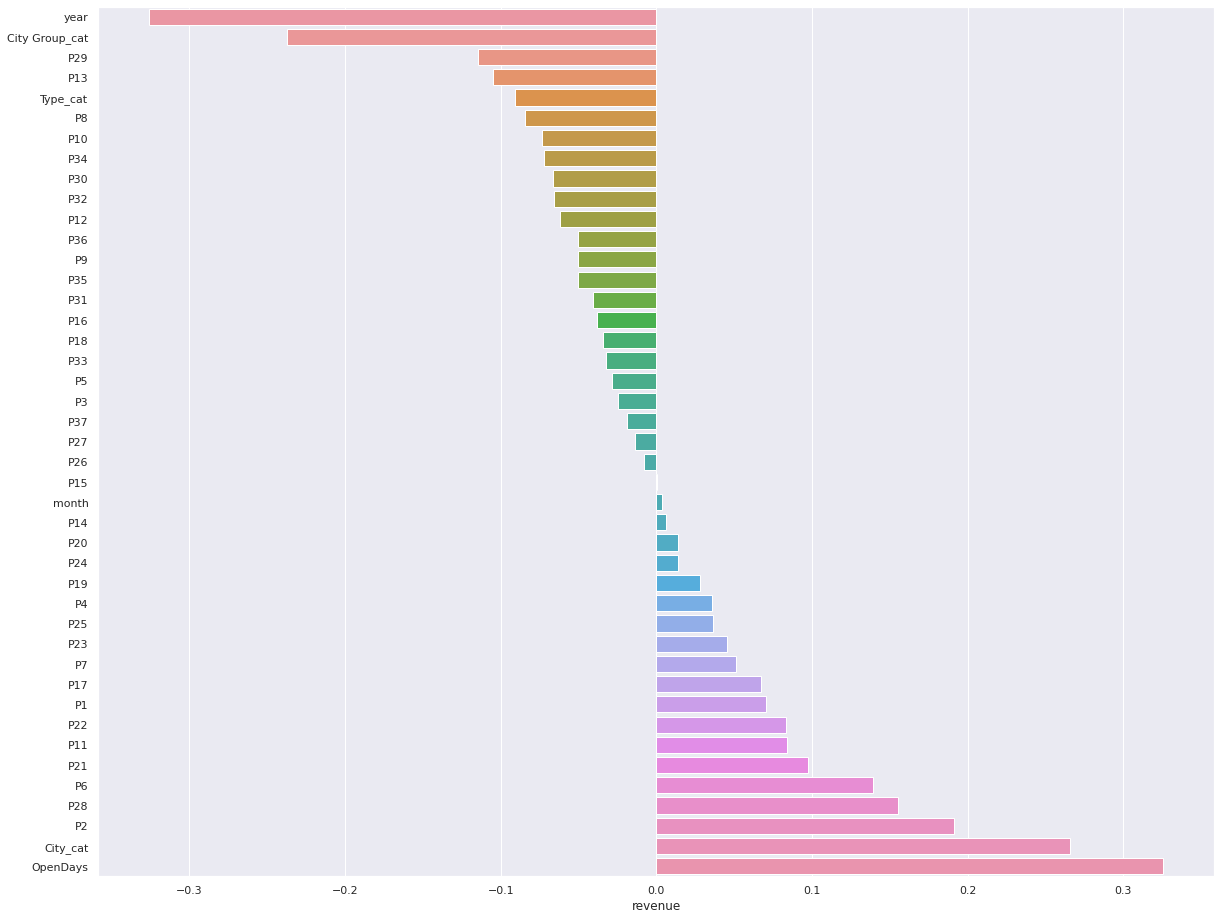

In [40]:
# Creating a plot for the correlation of features to the target variable
fig = plt.figure(figsize=(20,16))
target_corr = train[train.columns[1:]].corr()['revenue']
order_corr = target_corr.sort_values()
y = pd.DataFrame(order_corr).index[:-1]
x = pd.DataFrame(order_corr).revenue[:-1]
sns.barplot(x, y, orient='h')
plt.show()

So these bargraphs are giving out the same information. Now lets try to do same kind of stuffs for the newly generated feature 'year'.

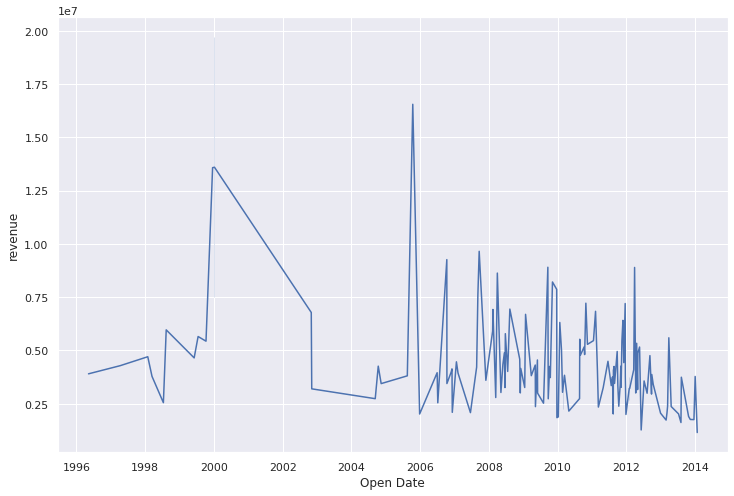

In [41]:
# Time Series of revenues generated
train_timeseries = pd.read_csv('/content/drive/MyDrive/train.csv.zip',
                             parse_dates=['Open Date'],
                             index_col= ['Open Date'],
                             na_values=['999.99'])
sns.lineplot(data=train_timeseries, x='Open Date', y='revenue')
plt.show()

# Data Pipelining 

Analyzing numerical features distribution

(0.0, 0.00766420280422317)

(0.0, 0.22519346847728638)

(0.0, 0.34402068027977095)

(0.0, 0.6760947869992868)

(0.0, 0.5968192919061798)

(0.0, 0.48929455914408515)

(0.0, 0.28351192348692655)

(0.0, 0.35829212933236326)

(0.0, 0.3637332943889673)

(0.0, 0.41055729043750383)

(0.0, 0.41673228344539714)

(0.0, 0.2429083941988277)

(0.0, 0.37228149570255903)

(0.0, 0.6425772508539453)

(0.0, 0.285223417171344)

(0.0, 0.31717261563985505)

(0.0, 0.21603425451586275)

(0.0, 0.38510778162452575)

(0.0, 0.2231150995961905)

(0.0, 0.1351753574164006)

(0.0, 0.1514247608110895)

(0.0, 0.34087008320774714)

(0.0, 0.357477259302744)

(0.0, 0.1674090475166917)

(0.0, 0.32990753172276943)

(0.0, 0.35593353487675494)

(0.0, 0.29408758702620713)

(0.0, 0.374971591286755)

(0.0, 0.2651510464544386)

(0.0, 0.4398187247477566)

(0.0, 0.1393053596468475)

(0.0, 0.22039904347650283)

(0.0, 0.1523013329207288)

(0.0, 0.4244164554006153)

(0.0, 0.15603961860571886)

(0.0, 0.21457149273810341)

(0.0, 0.18172330053105273)

(0.0, 0.41500182513485073)

(0.0, 2.2362589580815184e-07)

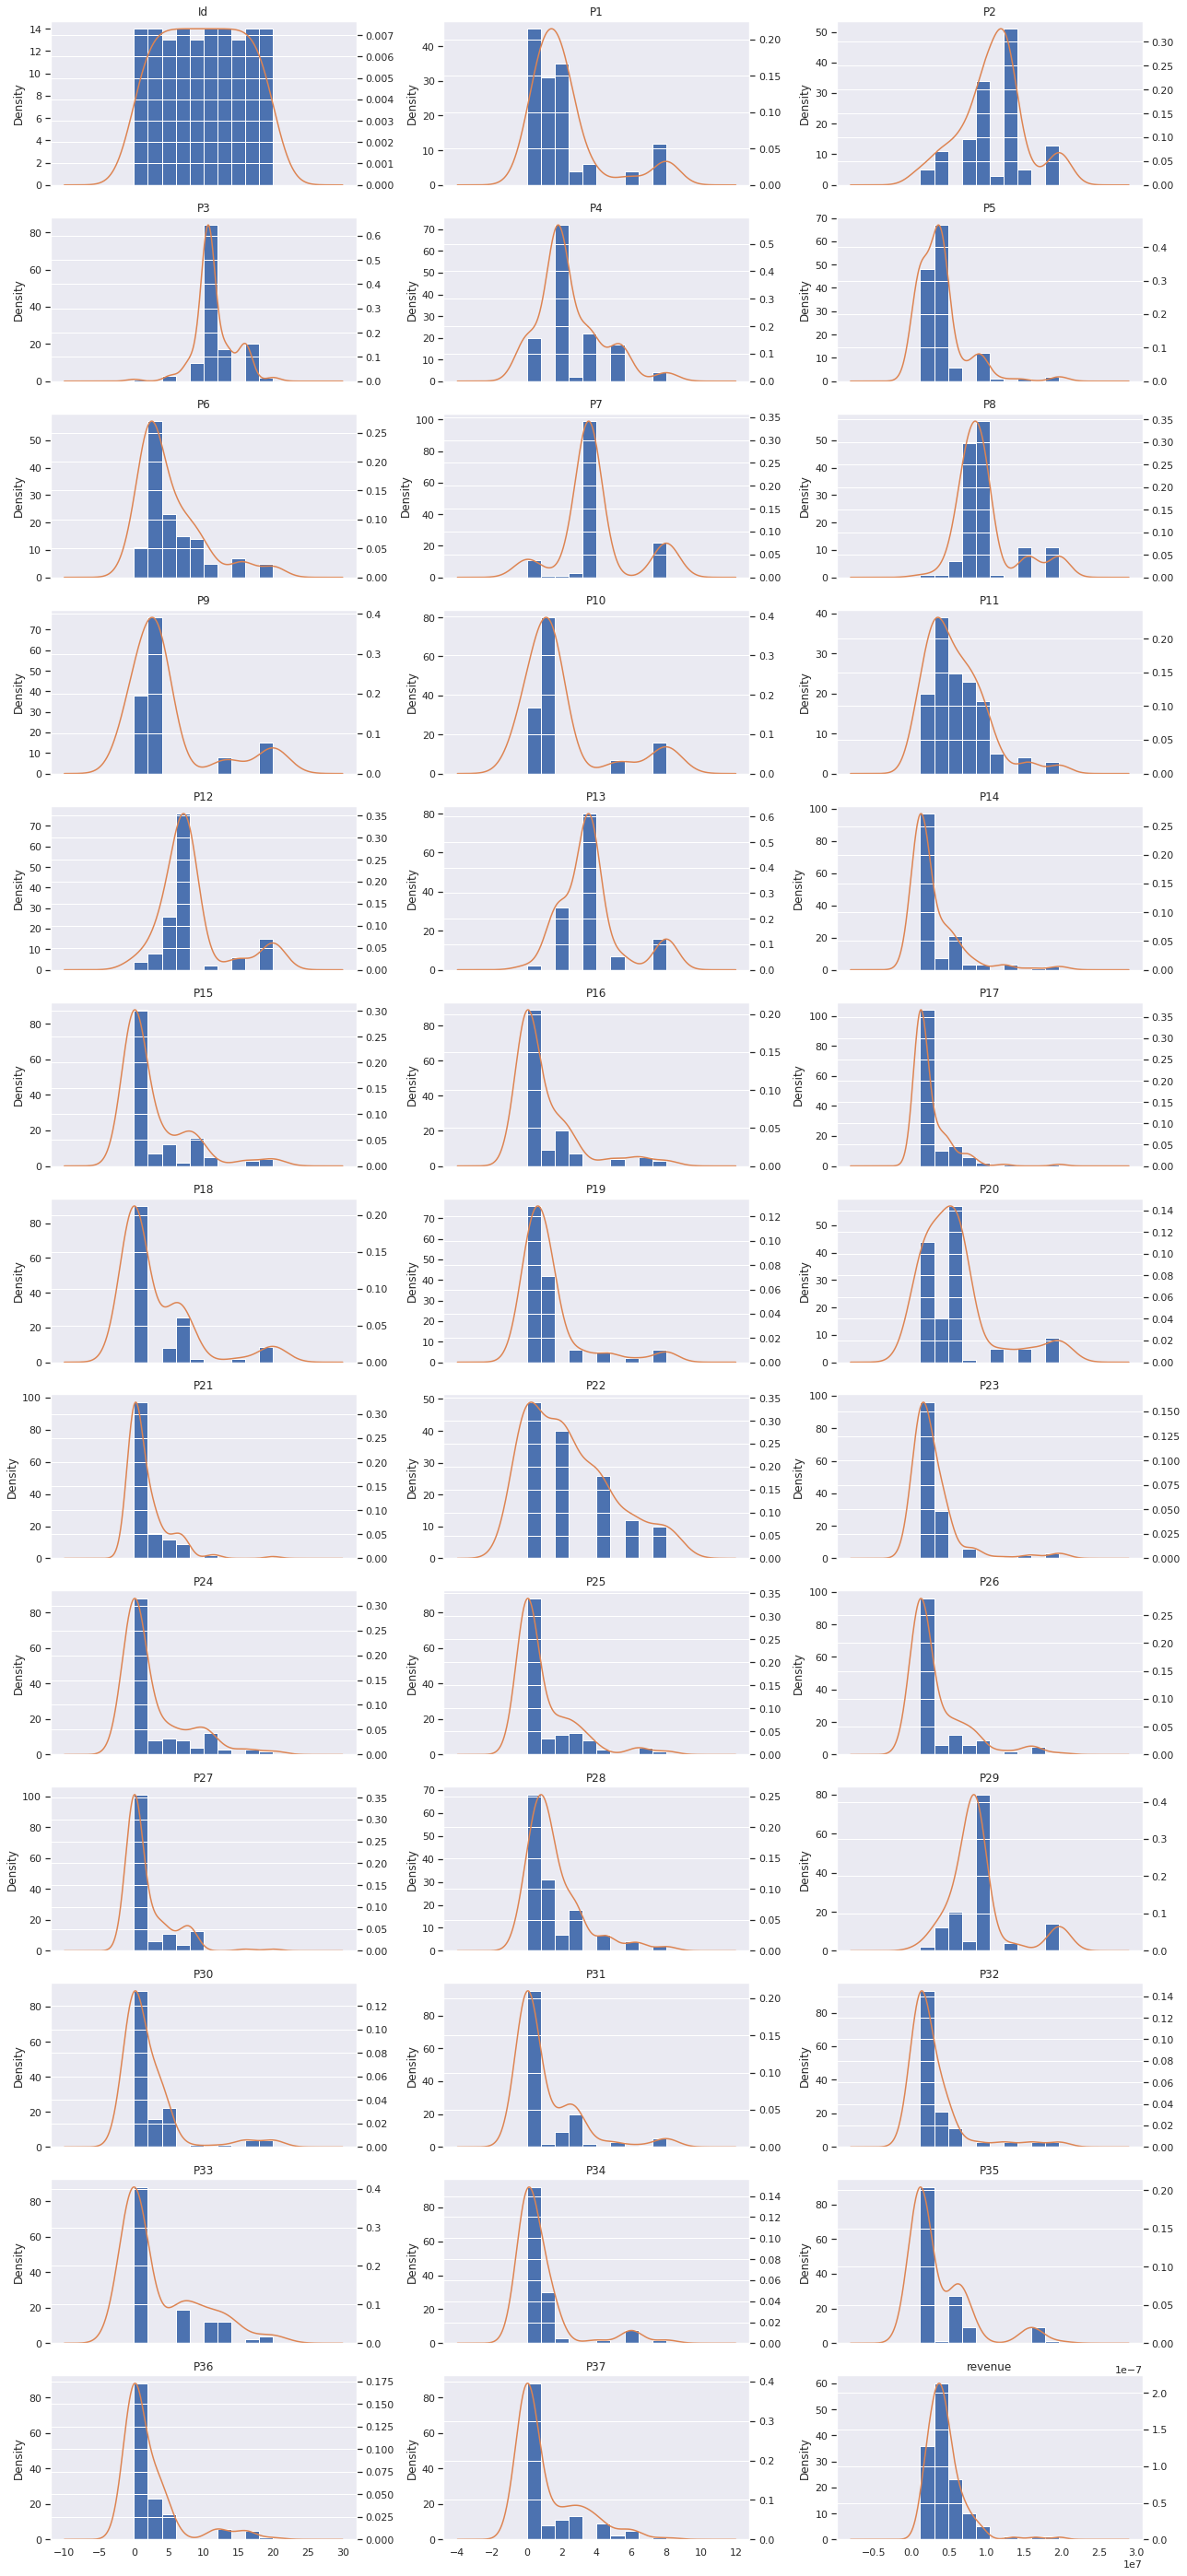

In [42]:
n = len(train[numerical_features].columns)
w = 3
h = (n - 1) // w + 1
fig, axes = plt.subplots(h, w, figsize=(w * 6, h * 3))
for i, (name, col) in enumerate(train[numerical_features].items()):
    r, c = i // w, i % w
    ax = axes[r, c]
    col.hist(ax=ax)
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name)
    ax2.set_ylim(0)

fig.tight_layout()

According to these histograms, it is clearly showing that most of the distributions are right-skewed. These non-normal distributions need to be studied carefully.

Analyzing categorical featrues

Text(0.5, 0, 'Open Date')

Text(0, 0.5, 'Total Revenue')

Text(0.5, 0, 'City')

Text(0, 0.5, 'Total Revenue')

Text(0.5, 0, 'City Group')

Text(0, 0.5, 'Total Revenue')

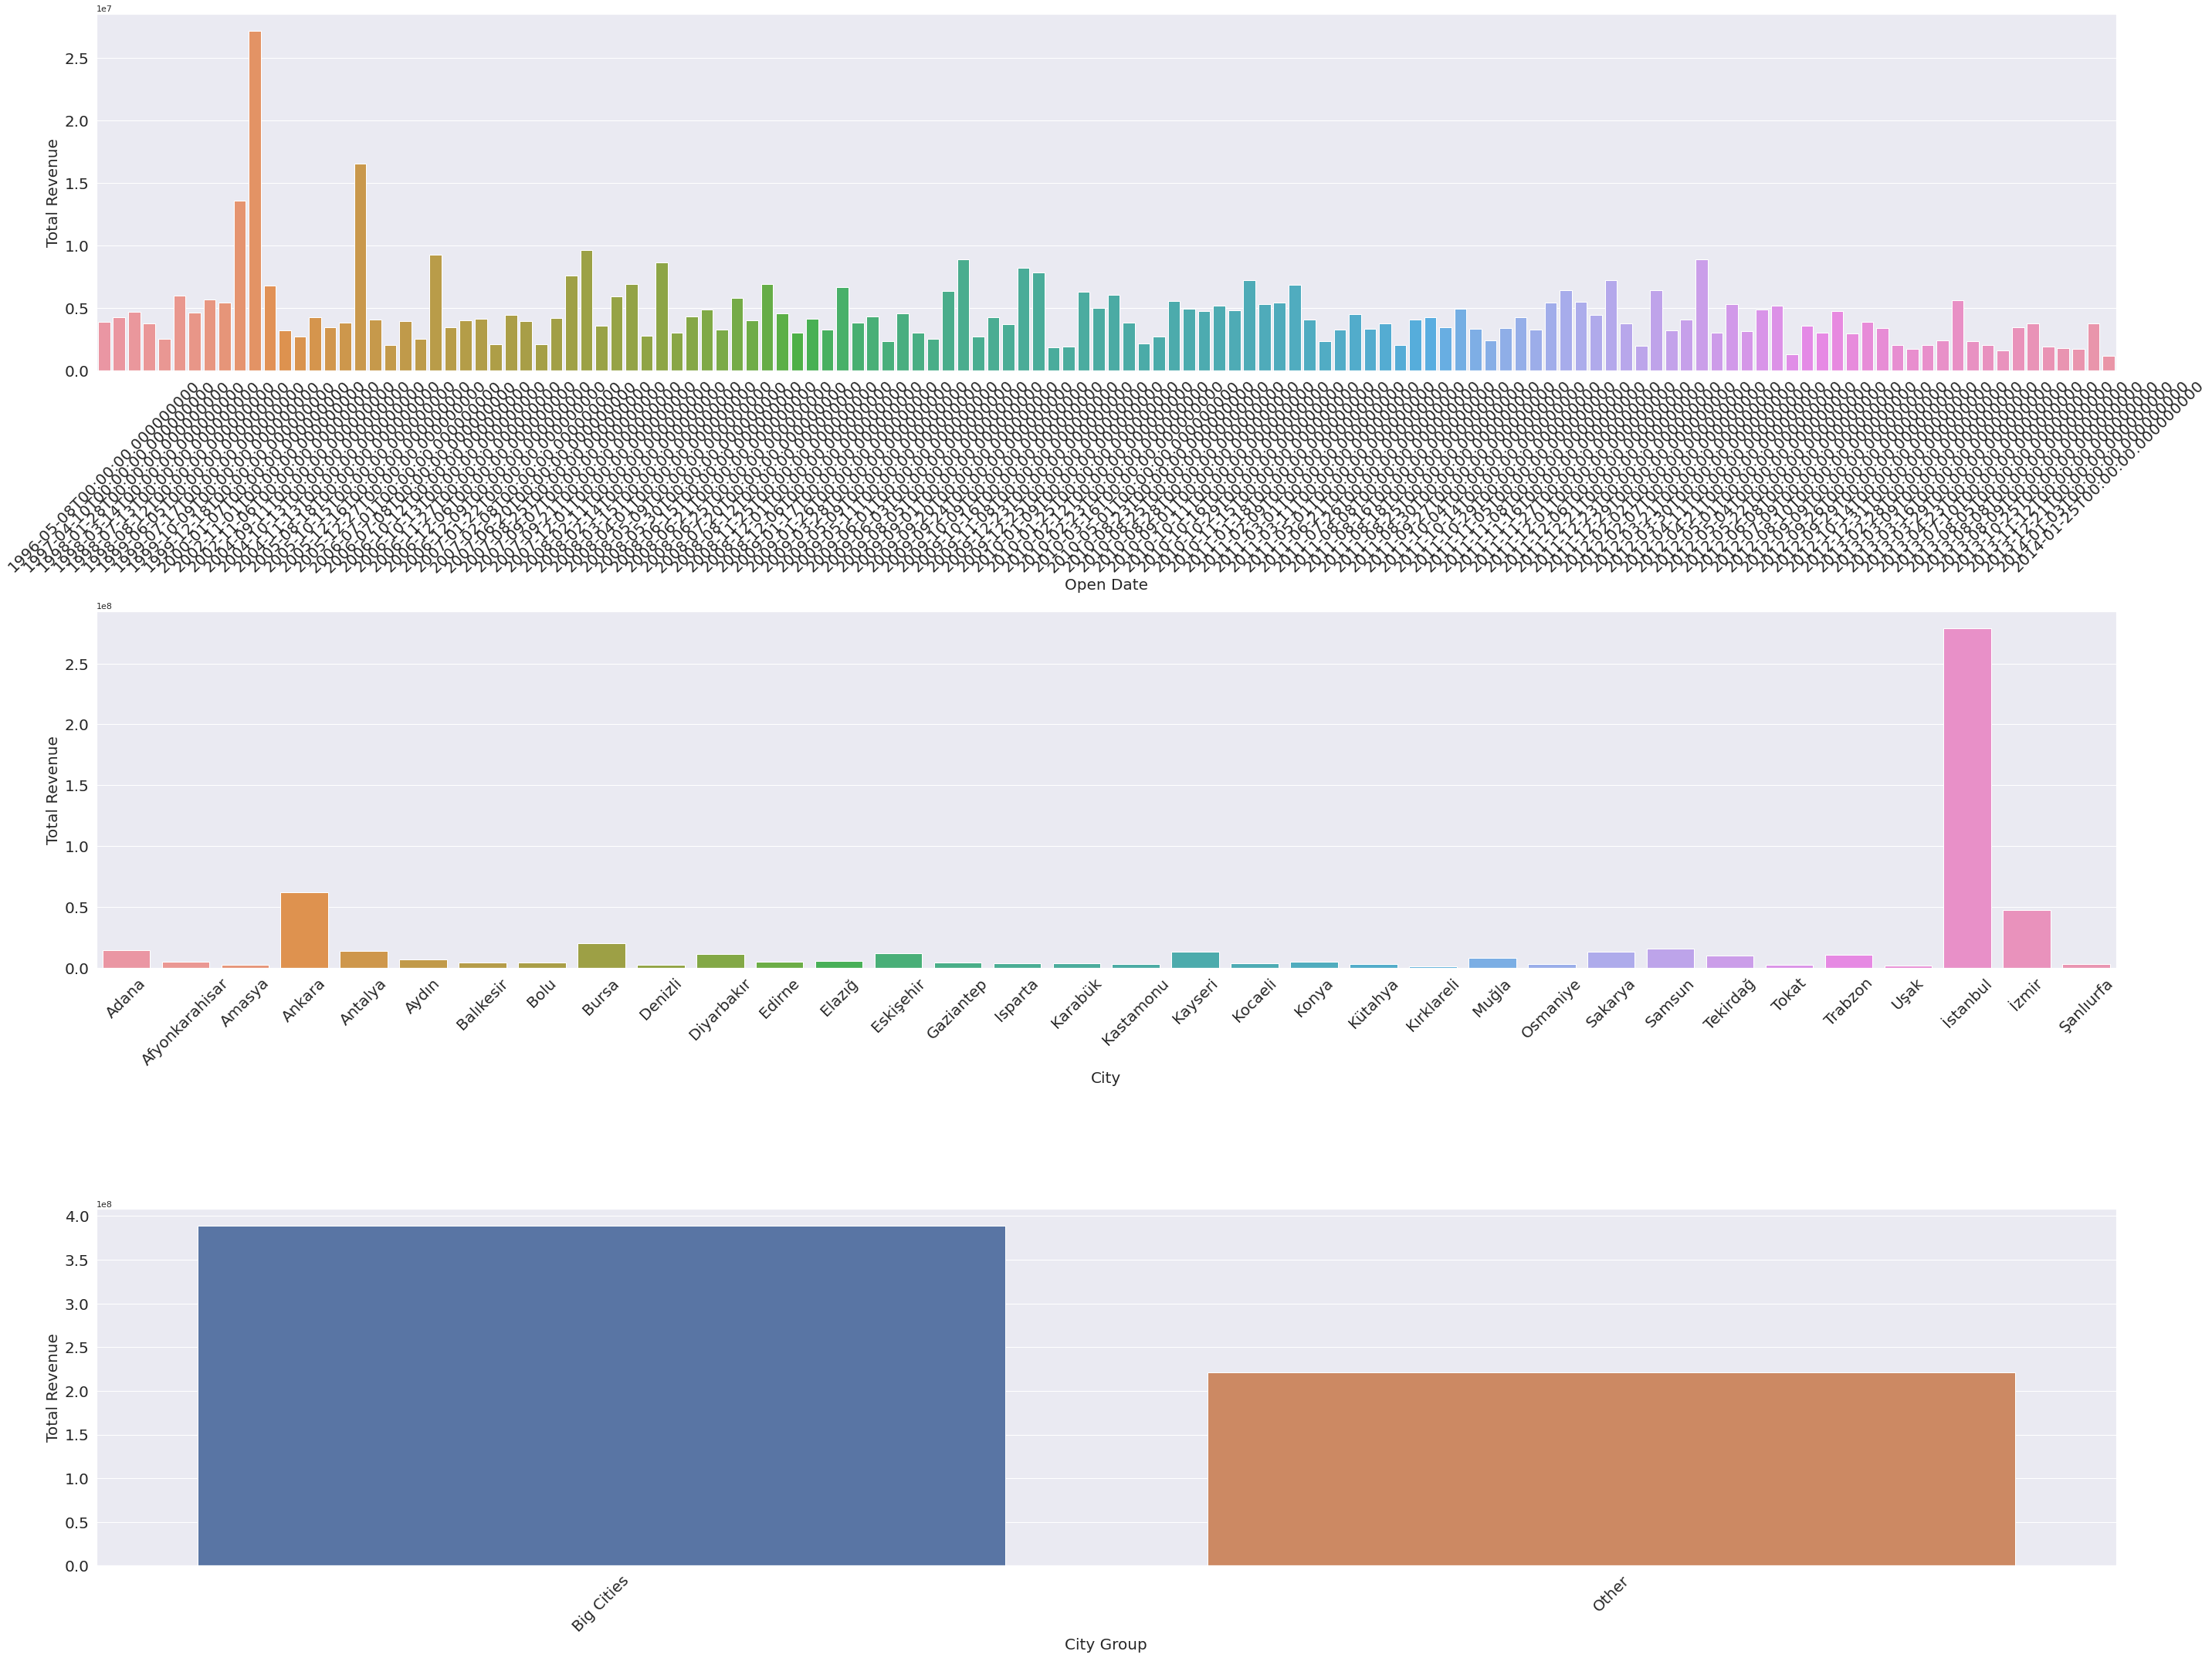

In [43]:
fig, ax = plt.subplots(3, 1, figsize=(40, 30))
for variable, subplot in zip(categorical_features, ax.flatten()):
    df_2 = train[[variable,'revenue']].groupby(variable).revenue.sum().reset_index()
    df_2.columns = [variable,'total_revenue']
    sns.barplot(x=variable, y='total_revenue', data=df_2 , ax=subplot)
    subplot.set_xlabel(variable,fontsize=20)
    subplot.set_ylabel('Total Revenue',fontsize=20)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)
        label.set_size(20)
    for label in subplot.get_yticklabels():
        label.set_size(20)
fig.tight_layout()

1. Restaurants in Istabul earn the most revenue in the dataset.
2. Restaurants in the big cities have higher total revenue than the others.
3. Restaurants in FC and IL city types have much higher total revenue than DT city type.

Relationships Between Attributes and Target Variables "Revenue":
Numerical Attributes

Text(0.5, 0, 'Id')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P1')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P2')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P3')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P4')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P5')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P6')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P7')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P8')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P9')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P10')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P11')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P12')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P13')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P14')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P15')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P16')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P17')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P18')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P19')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P20')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P21')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P22')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P23')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P24')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P25')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P26')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P27')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P28')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P29')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P30')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P31')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P32')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P33')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P34')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P35')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P36')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'P37')

Text(0, 0.5, 'Revenue')

Text(0.5, 0, 'revenue')

Text(0, 0.5, 'Revenue')

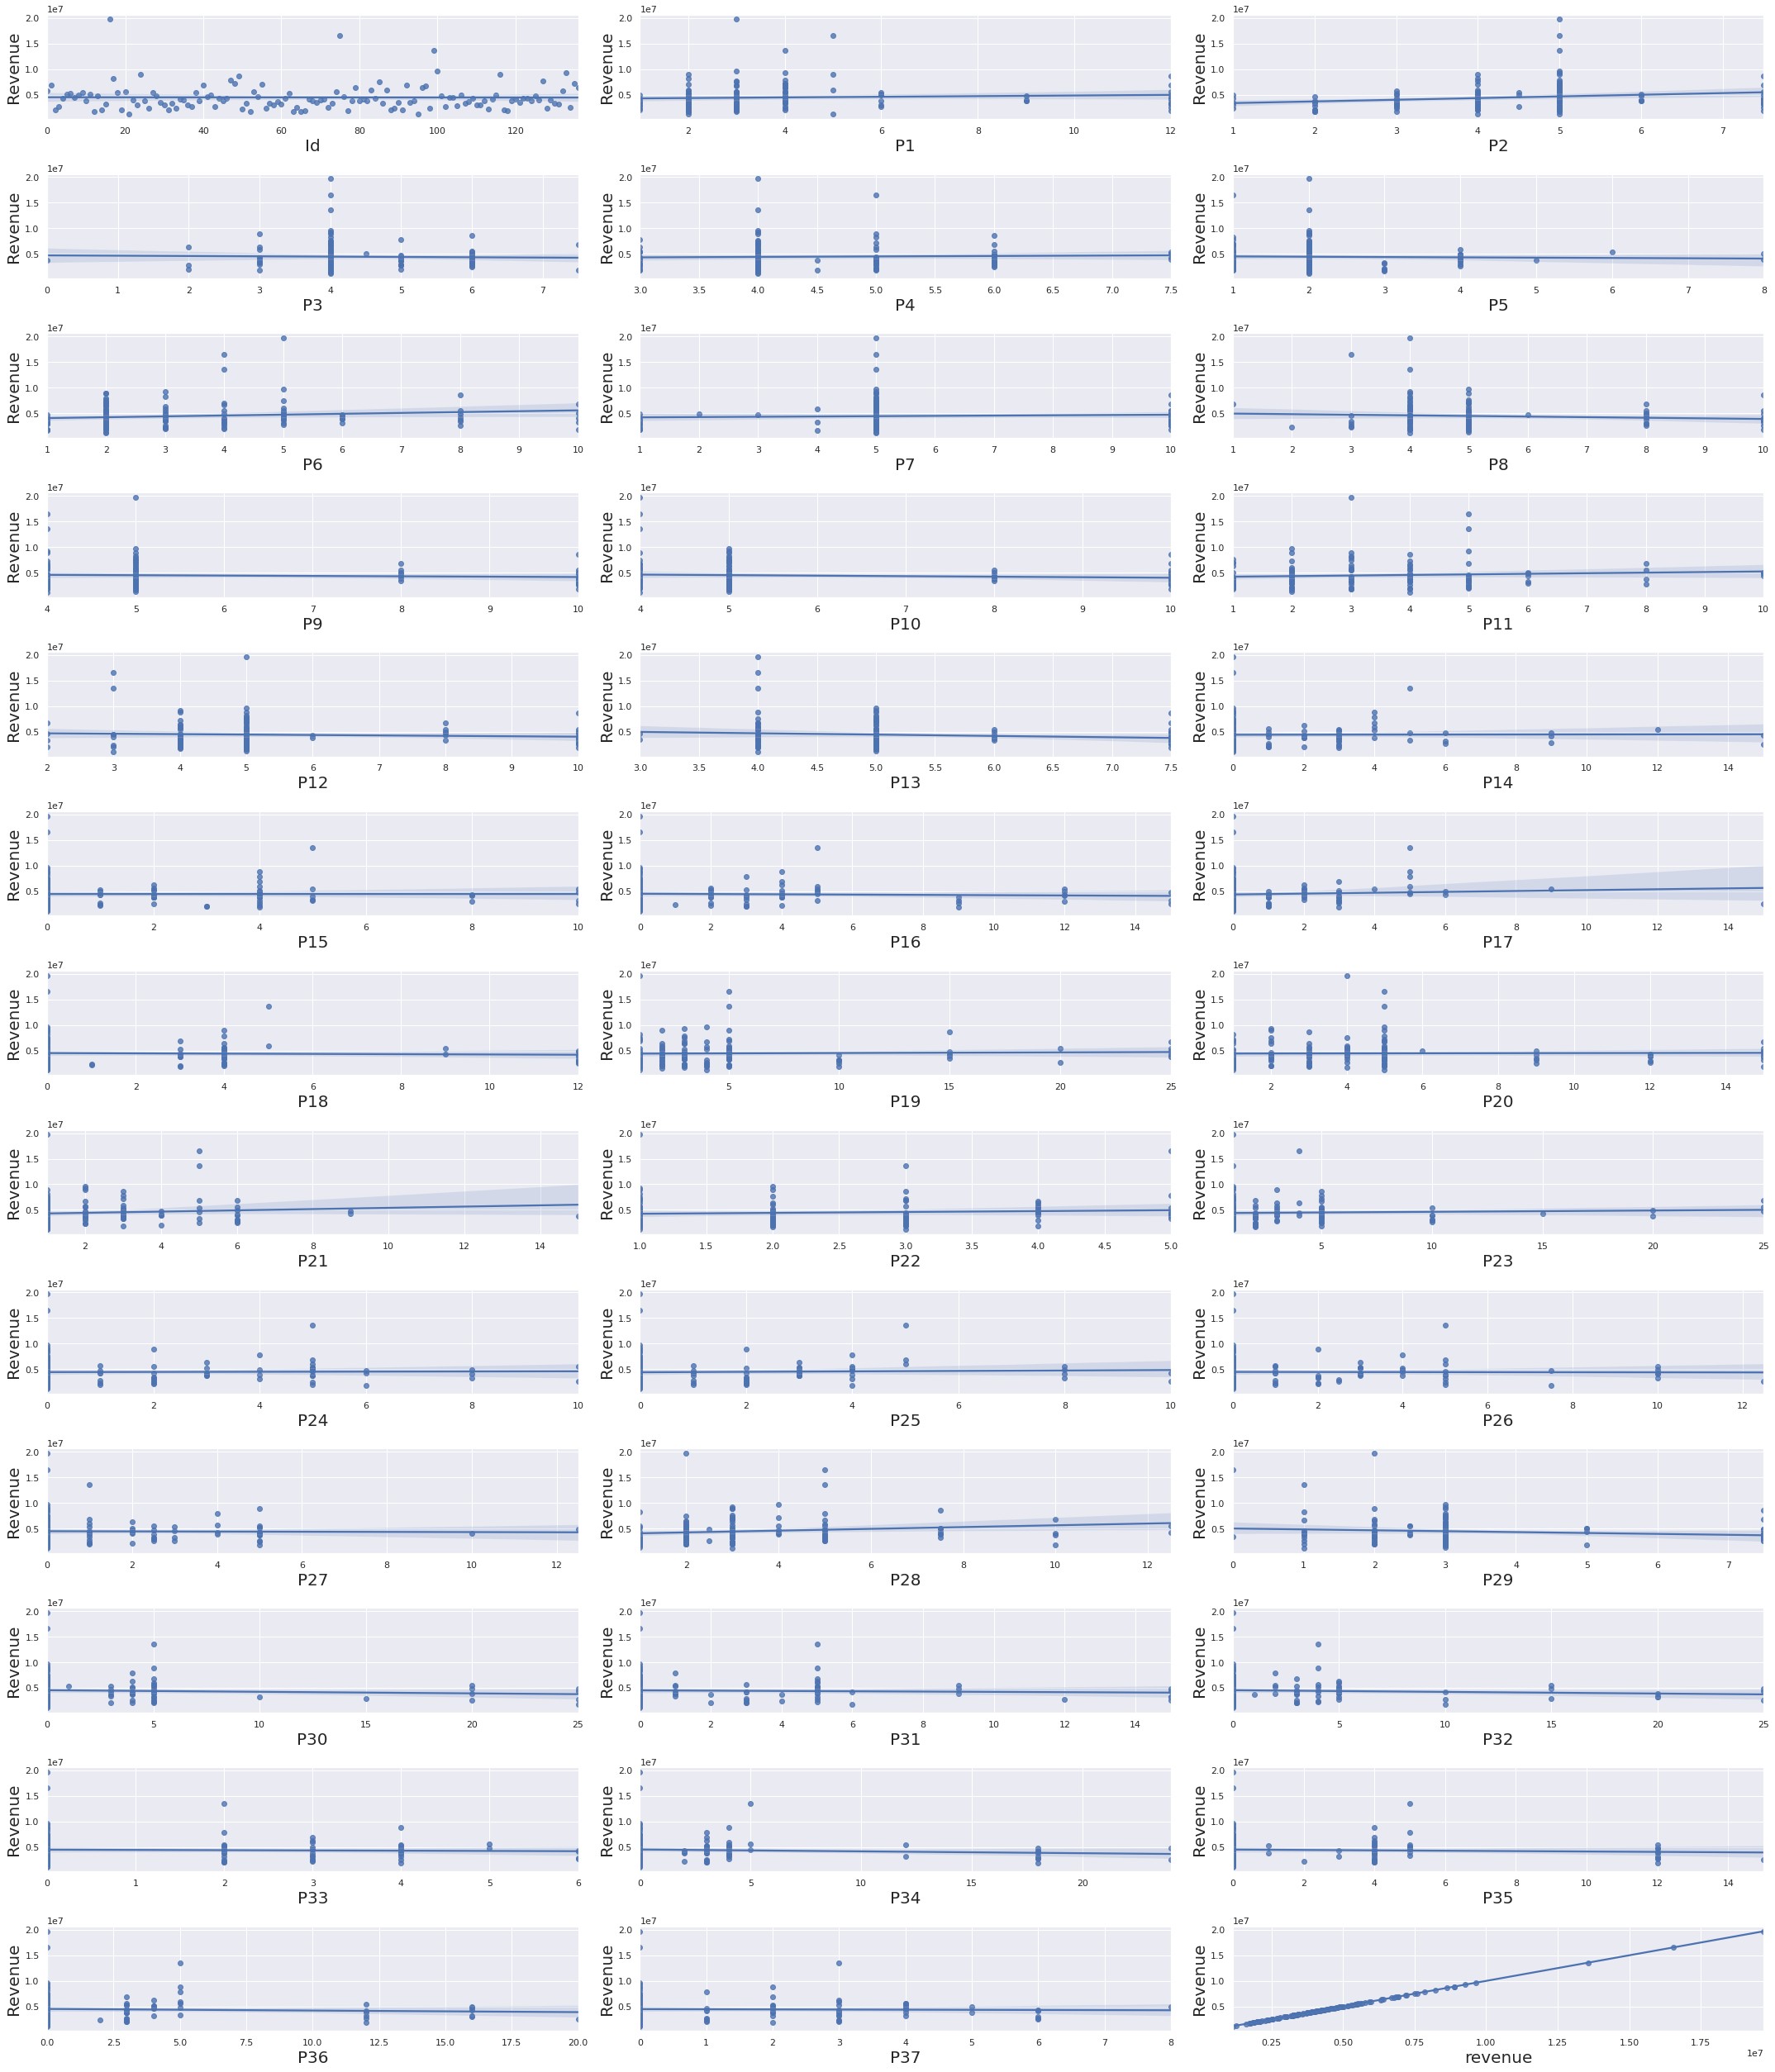

In [47]:
fig, ax = plt.subplots(13, 3, figsize=(30, 35))
for variable, subplot in zip(numerical_features, ax.flatten()):
    sns.regplot(x=train[variable], y=train['revenue'], ax=subplot)
    subplot.set_xlabel(variable,fontsize=20)
    subplot.set_ylabel('Revenue',fontsize=20)
fig.tight_layout()

In [ ]:
plt.figure(figsize=(45,25))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
sns.heatmap(df.corr(),annot=True, mask=mask)
sns.set(font_scale=1.4)

According to linear regression graphs and heatmap of correlation scores, these numerical attributes have very weak linear relationship with the target variable "Revenue". The highest correlation score is 'Age' which is 0.2, meanwhile the others have nearly 0 correlation score. However, there are groups of attributes which have high correlation to each others.


In [50]:
#Lets take a look at city group field 
print("--- Train set ---")
print(train['City Group'].value_counts())
print("---- Test set ----")
print(train['City Group'].value_counts())


--- Train set ---
Big Cities    78
Other         59
Name: City Group, dtype: int64
---- Test set ----
Big Cities    78
Other         59
Name: City Group, dtype: int64


In [ ]:
#Lets take a look at type field 
print("--- Train set ---")
print(train['Type'].value_counts())
print("---- Test set ----")
print(train['Type'].value_counts())

There is no MB restaurant type in the train dataset.

# Feature Transformation

In [51]:
# Checking the options in both city, city_group, and Type
# to evaluate if categorical encoding may be necessary
print(train.City.unique(), len(train.City.unique()))
print(train['City Group'].unique(), len(train['City Group'].unique()))
print(train['Type'].unique(), len(train['Type'].unique()))

['İstanbul' 'Ankara' 'Diyarbakır' 'Tokat' 'Gaziantep' 'Afyonkarahisar'
 'Edirne' 'Kocaeli' 'Bursa' 'İzmir' 'Sakarya' 'Elazığ' 'Kayseri'
 'Eskişehir' 'Şanlıurfa' 'Samsun' 'Adana' 'Antalya' 'Kastamonu' 'Uşak'
 'Muğla' 'Kırklareli' 'Konya' 'Karabük' 'Tekirdağ' 'Denizli' 'Balıkesir'
 'Aydın' 'Amasya' 'Kütahya' 'Bolu' 'Trabzon' 'Isparta' 'Osmaniye'] 34
['Big Cities' 'Other'] 2
['IL' 'FC' 'DT'] 3


In [52]:
def encode_and_bind(train, feature):
    dummies = pd.get_dummies(train[[feature]], prefix='')
    return pd.concat([train, dummies], axis=1)
train = encode_and_bind(train, 'City')
train = encode_and_bind(train, 'City Group')
train = encode_and_bind(train, 'Type')
train.head(3)

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,...,year,_Adana,_Afyonkarahisar,_Amasya,_Ankara,_Antalya,_Aydın,_Balıkesir,_Bolu,_Bursa,_Denizli,_Diyarbakır,_Edirne,_Elazığ,_Eskişehir,_Gaziantep,_Isparta,_Karabük,_Kastamonu,_Kayseri,_Kocaeli,_Konya,_Kütahya,_Kırklareli,_Muğla,_Osmaniye,_Sakarya,_Samsun,_Tekirdağ,_Tokat,_Trabzon,_Uşak,_İstanbul,_İzmir,_Şanlıurfa,_Big Cities,_Other,_DT,_FC,_IL
0,0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,...,1999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
1,1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,...,2008,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,...,2013,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [53]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [56]:
# P variables will be considered as continous variables rather than categorical variables
imp_train = IterativeImputer(max_iter=5, random_state=0, missing_values=0, sample_posterior = True, min_value=1)
p_vals = ["P" + str(i) for i in range(1, 38)]
train[p_vals] = np.round(imp_train.fit_transform(train[p_vals]))

# Model Building

In [65]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split


In [58]:
# Features and Target 
X = train.drop(['revenue', 'Open Date', 'City', 'City Group', 'Type'], axis=1).values
y = train['revenue'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=202)


In [59]:
#Standard scaling for model efficiency
from sklearn.preprocessing import StandardScaler

sc = StandardScaler(with_std = True ,with_mean = True, copy = True)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [60]:
# Multiple Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error ,mean_squared_error

reg1 = LinearRegression().fit(X_train, y_train)
y_pred = reg1.predict(X_test)

rmse = skm.mean_squared_error(y_test, y_pred, squared=False)
mae=mean_absolute_error(y_test,y_pred)


print("RMSE: {0}".format(rmse))
print("MAE: {0}".format(mae))

RMSE: 4846063.680447508
MAE: 4091707.141080715


In [61]:
reg1.score(X_train, y_train)

0.7452715728065243

In [62]:
# Single Tree Regression

reg2 = DecisionTreeRegressor(max_depth=10)
reg2.fit(X_train, y_train)
y_pred = reg2.predict(X_test)

rmse = skm.mean_squared_error(y_test, y_pred, squared=False)
mae=mean_absolute_error(y_test,y_pred)


print("RMSE: {0}".format(rmse))
print("MAE: {0}".format(mae))

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

RMSE: 3316231.530210294
MAE: 2294484.482323232


In [63]:
pred = reg2.predict(X_test)
pred = np.exp(pred)
scoreOfModel=reg2.score(X_train, y_train)
print("Score is calculated as: ",scoreOfModel)

Score is calculated as:  0.9950892876856444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [66]:
# Random Forest

reg3 = RandomForestRegressor(n_estimators=1000, criterion="mse")
reg3.fit(X_train, y_train)
y_pred = reg3.predict(X_test)

rmse = skm.mean_squared_error(y_test, y_pred, squared=False)
mae=mean_absolute_error(y_test,y_pred)


print("RMSE: {0}".format(rmse))
print("MAE: {0}".format(mae))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

RMSE: 2360688.8589611254
MAE: 1826190.6531904761


In [67]:
pred = reg3.predict(X_test)
pred = np.exp(pred)
scoreOfModel=reg3.score(X_train, y_train)
print("Score is calculated as: ",scoreOfModel)

Score is calculated as:  0.8445812561727355


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [68]:
import xgboost as xgb

reg4 = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,
                 reg_alpha=0.75,
                 subsample=0.6,
                 seed=42)
xgbr=reg4.fit(X_train, y_train)
y_pred = reg4.predict(X_test)

rmse = skm.mean_squared_error(y_test, y_pred, squared=False)
mae=mean_absolute_error(y_test,y_pred)

              
print("RMSE: {0}".format(rmse))
print("MAE: {0}".format(mae))

[16:21:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 2279147.121872923
MAE: 1853377.767857143


In [69]:
xgbrscoreofModel=xgbr.score(X_train, y_train)
print("Score is calculated as: ",xgbrscoreofModel)

Score is calculated as:  0.9999999999975777
